TensorFlow Version: 2.7.0
Local copy of the file: C:\Users\diamo\.keras\datasets\iris_training.csv
Epoch 000: Loss: 1.213, Accuracy: 35.000%
Epoch 050: Loss: 0.091, Accuracy: 97.500%
Epoch 100: Loss: 0.066, Accuracy: 98.333%
Epoch 150: Loss: 0.065, Accuracy: 97.500%
Epoch 200: Loss: 0.063, Accuracy: 97.500%
Epoch 250: Loss: 0.044, Accuracy: 98.333%
Epoch 300: Loss: 0.044, Accuracy: 99.167%
Epoch 350: Loss: 0.065, Accuracy: 96.667%
Epoch 400: Loss: 0.042, Accuracy: 99.167%
Epoch 450: Loss: 0.073, Accuracy: 98.333%


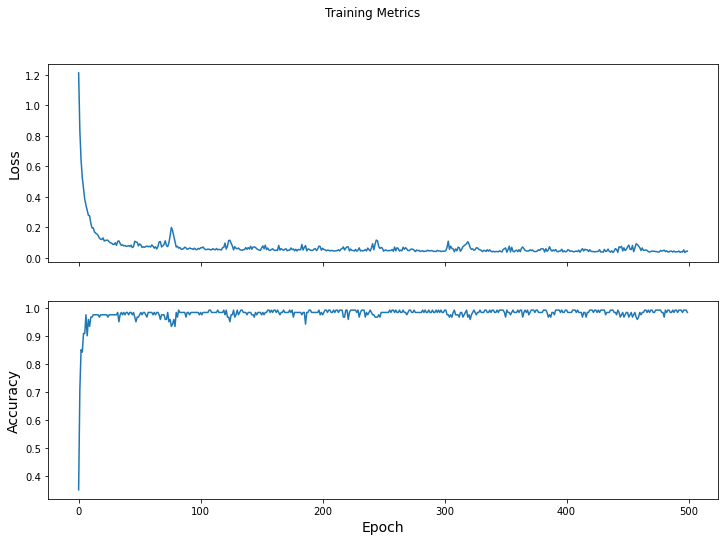

Test set accuracy: 96.667%


In [2]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

#preprocesses data before using
def prepare_data():
    #string 내부에 대괄호를 넣으면 C처럼 포맷을 할 수 있다. 사실 %d같은 걸로도 되긴 된다.
    print('TensorFlow Version: {}'.format(tf.__version__))

    #loading the dataset from the web
    train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"
    train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url), origin=train_dataset_url)
    print('Local copy of the file: {}'.format(train_dataset_fp))

    #defining the columns by name
    column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
    feature_columns = column_names[:-1]
    label_name = column_names[-1]
    #name of categorized labels
    class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

    #preparing the dataset
    batch_size = 32
    train_dataset = tf.data.experimental.make_csv_dataset(
        train_dataset_fp, #file
        batch_size,
        column_names = column_names,
        label_name = label_name,
        num_epochs=1
    )

    #prepare features

    #features, labels = next(iter(train_dataset))
    #print(features)
    #
    # OrderedDict([('sepal_length', <tf.Tensor: shape=(32,), dtype=float32, numpy=
    # array([6. , 5.7, 6.9, 6.4, 6.4, 5. , 5.2, 5. , 5. , 5. , 6.4, 7.7, 4.9,
    #    5.7, 6.5, 6.7, 7.2, 6.8, 6.4, 5.1, 6.5, 6. , 6.3, 6.7, 6.9, 5.5,
    #    5.1, 7.4, 7.2, 6. , 5.8, 5.9], dtype=float32)>), ('sepal_width', <tf.Tensor: shape=(32,), dtype=float32, numpy=
    # array([2.7, 2.9, 3.2, 3.2, 2.7, 3.6, 2.7, 3.4, 3.5, 3.2, 3.2, 2.6, 3. ,
    #    3. , 3. , 3.1, 3.2, 3. , 2.8, 3.5, 3.2, 3. , 2.5, 3. , 3.1, 2.6,
    #    3.8, 2.8, 3.6, 2.9, 2.7, 3. ], dtype=float32)>), ('petal_length', <tf.Tensor: shape=(32,), dtype=float32, numpy=
    # array([5.1, 4.2, 5.7, 4.5, 5.3, 1.4, 3.9, 1.5, 1.6, 1.2, 5.3, 6.9, 1.4,
    #    4.2, 5.2, 4.4, 6. , 5.5, 5.6, 1.4, 5.1, 4.8, 5. , 5. , 4.9, 4.4,
    #    1.6, 6.1, 6.1, 4.5, 5.1, 5.1], dtype=float32)>), ('petal_width', <tf.Tensor: shape=(32,), dtype=float32, numpy=
    # array([1.6, 1.3, 2.3, 1.5, 1.9, 0.2, 1.4, 0.2, 0.6, 0.2, 2.3, 2.3, 0.2,
    #    1.2, 2. , 1.4, 1.8, 2.1, 2.2, 0.3, 2. , 1.8, 1.9, 1.7, 1.5, 1.2,
    #    0.2, 1.9, 2.5, 1.5, 1.9, 1.8], dtype=float32)>)])

    #lambda func to map from array of each feature to features of each entry
    #작동원리 잘 이해 안됨
    mapping = lambda features, label: (tf.stack(list(features.values()), axis=1), label)
    train_dataset = train_dataset.map(mapping)
    
    features, labels = next(iter(train_dataset))
    # print(features)
    # tf.Tensor(
    # [[4.8 3.  1.4 0.1]
    # [5.1 3.5 1.4 0.3]
    # [5.4 3.  4.5 1.5]
    # [4.9 2.4 3.3 1. ]

    return train_dataset, features, labels
    
#builds keras sequential model
def build_model():
    model = Sequential([
        Dense(10, activation='relu'),
        Dense(10, activation='relu'),
        Dense(3)
    ])

    return model

#trains keras sequential model
def train_model(model, features, labels, train_dataset):
    #calculating loss
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    loss = lambda model, x, y, training: loss_object(y_true=y, y_pred=model(x, training=training))
    l = loss(model, features, labels, training=False)

    #gradient function
    def grad(model, inputs, targets):
        with tf.GradientTape() as tape:
            loss_value = loss(model, inputs, targets, training=True)
        return loss_value, tape.gradient(loss_value, model.trainable_variables)
    
    #optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    #tf.keras.optimizers.M
    train_loss_results = []
    train_accuracy_results = []
    num_epochs = 500

    for epoch in range(num_epochs):
        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

        for x, y in train_dataset:
            #print(x,y)

            #get the gradient
            loss_value, grads = grad(model, x, y)
            #apply the gradient
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
                    
            # Track progress
            epoch_loss_avg.update_state(loss_value)  # Add current batch loss
            # Compare predicted label to actual label
            # training=True is needed only if there are layers with different
            # behavior during training versus inference (e.g. Dropout).
            epoch_accuracy.update_state(y, model(x, training=True))
        
          # End epoch
        train_loss_results.append(epoch_loss_avg.result())
        train_accuracy_results.append(epoch_accuracy.result())

        if epoch % 50 == 0:
            print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

    fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
    fig.suptitle('Training Metrics')

    axes[0].set_ylabel("Loss", fontsize=14)
    axes[0].plot(train_loss_results)

    axes[1].set_ylabel("Accuracy", fontsize=14)
    axes[1].set_xlabel("Epoch", fontsize=14)
    axes[1].plot(train_accuracy_results)
    # `plt.show()` will display a figure
    plt.show()

    return model

#tests the model
def test_model(model):
    test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

    # The `tf.keras.utils.get_file` will downloads a file from a URL if it not already in the cache.
    test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)
    batch_size=32                              
    column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
    # The `tf.data.experimental.make_csv_dataset()` method reads CSV files into a dataset
    test_dataset = tf.data.experimental.make_csv_dataset(
        test_fp,
        batch_size,
        column_names=column_names,
        label_name='species',
        num_epochs=1,
        shuffle=False)

    mapping = lambda features, label: (tf.stack(list(features.values()), axis=1), label)
    # The `map()` method will pack the `features` into the training dataset:
    test_dataset = test_dataset.map(mapping)
    test_accuracy = tf.keras.metrics.Accuracy()

    for (x, y) in test_dataset:
    # training=False is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
        logits = model(x, training=False)
        prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
        test_accuracy(prediction, y)

    print("Test set accuracy: {:.3%}".format(test_accuracy.result()))


#main
def main():
    training_data, features, labels = prepare_data()
    model = build_model()
    model = train_model(model, features, labels, training_data)
    test_model(model)

main()